# House Price Prediction with XGBoost | Numerical Data Only Version


This notebook demonstrates the application of XGBoost regression to the House Prices Dataset. The goal is to create a model that accurately predicts house prices by preprocessing numerical features, handling missing values, and evaluating model performance through cross-validation.


Link: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

### Load training dataset into pd Dataframe

In [2]:
training_data_path = "/kaggle/input/house-prices-advanced-regression-techniques/train.csv"
df_full = pd.read_csv(training_data_path, index_col=0)
df_full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
target='SalePrice'
cat_cols = [col for col in df_full.columns if df_full[col].dtype=="object"]
num_cols = [col for col in df_full.columns if col not in cat_cols]
print(num_cols)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


### Numerical Data : Low Correlation
Drop columns with minimal correlation (less than 0.35) to Sale Price

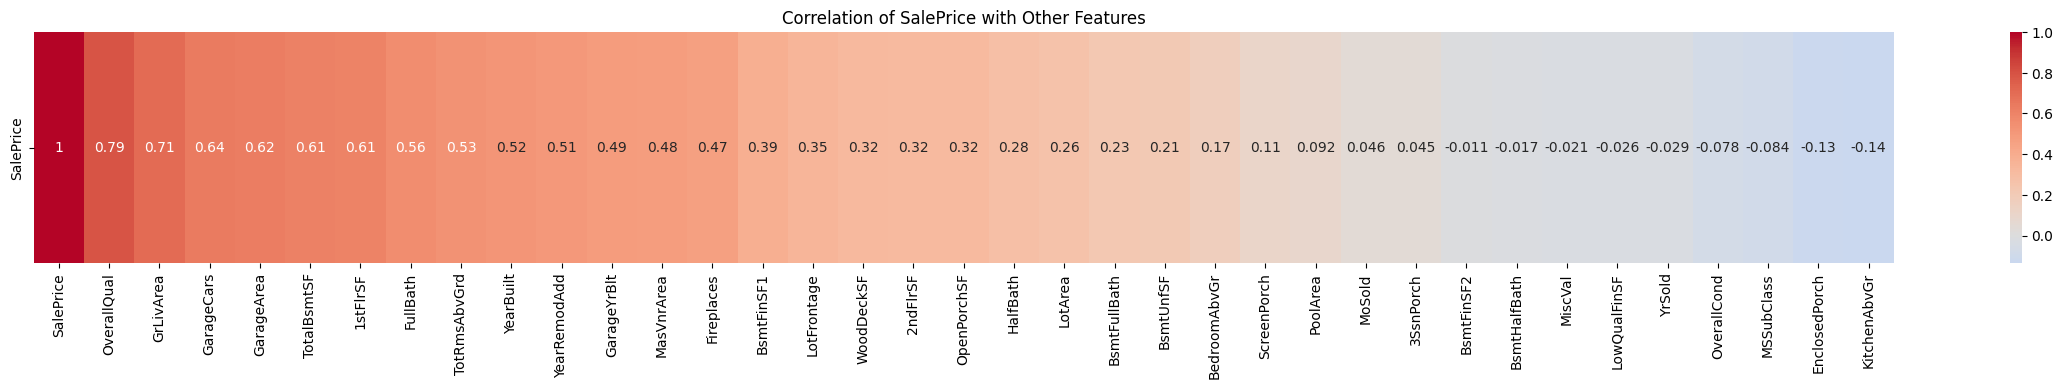

In [4]:
# Calculate the correlation matrix
corr_matrix = df_full[num_cols].corr()

# Extract the correlation of 'Sale Price' with all other columns
corr_target = corr_matrix[[target]].sort_values(by=target, ascending=False)

# Transpose for easier visualization
corr_target = corr_target.T

# Plot the heatmap
plt.figure(figsize=(30, 3))
sns.heatmap(corr_target, annot=True, cmap='coolwarm', center=0)
plt.title(f'Correlation of {target} with Other Features')
plt.show()

In [5]:
# Find features with little to no correlation to Sale Price
corr_target = corr_matrix[target]

# Sort the correlations and get the column names
sorted_columns = corr_target.sort_values(ascending=False).index.tolist()

# Display low correlation column names to drop
low_corr_cols = sorted_columns[16:]
print("Low correlation columns to be dropped later:")
print(low_corr_cols)

Low correlation columns to be dropped later:
['WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'HalfBath', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'ScreenPorch', 'PoolArea', 'MoSold', '3SsnPorch', 'BsmtFinSF2', 'BsmtHalfBath', 'MiscVal', 'LowQualFinSF', 'YrSold', 'OverallCond', 'MSSubClass', 'EnclosedPorch', 'KitchenAbvGr']


### Numerical Columns: Missing Data
Drop sparsely populated columns (>50% empty)

(None)

In [6]:
# Find # of empty entries per column
sparse_cols=[]

print(f"Numerical columns with at leat one null value entry:")
for col in num_cols:
    num_null = df_full[col].isna().sum()
    
    if num_null: # Print out all cols with at least one null
        percent_empty = num_null/df_full.shape[0]
        print(f"{round(percent_empty, 2)*100}% empty,\t{num_null} null,\t{col}")
        
        if percent_empty > 0.5: # Drop all columns more than 50% empty
            sparse_cols.append(col)

sparse_cols

Numerical columns with at leat one null value entry:
18.0% empty,	259 null,	LotFrontage
1.0% empty,	8 null,	MasVnrArea
6.0% empty,	81 null,	GarageYrBlt


[]

### Categorical Columns: Missing Data
Drop sparsely populated columns (>50% empty)

In [7]:
# Find # of empty entries per column
print(df_full.shape)
sparse_cols=[]

print(f"Sparse categorical columns to be dropped later:")
for col in cat_cols:
    num_null = df_full[col].isna().sum()
    
    if num_null: # Print out all cols with at least one null
        percent_empty = num_null/df_full.shape[0]
        
        if percent_empty > 0.5: # Drop all columns more than 50% empty
            print(f"{round(percent_empty, 2)*100}% empty,\t{num_null} null,\t{col}")
            sparse_cols.append(col)

(1460, 80)
Sparse categorical columns to be dropped later:
94.0% empty,	1369 null,	Alley
60.0% empty,	872 null,	MasVnrType
100.0% empty,	1453 null,	PoolQC
81.0% empty,	1179 null,	Fence
96.0% empty,	1406 null,	MiscFeature


In [8]:
# Drop columns
print("Dropping columns...")
df = df_full.drop(low_corr_cols+sparse_cols, axis=1)
print("Done")

new_num_cols = [col for col in num_cols if col not in low_corr_cols]
new_cat_cols = [col for col in cat_cols if col not in sparse_cols]

Dropping columns...
Done


### Train Test Split

In [9]:
from sklearn.model_selection import train_test_split
df_num = df.drop(new_cat_cols, axis=1) # Reduce df to numerical columns only

X = df_num.drop(target, axis=1)
y = df_num[target]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)
X_valid.shape

(292, 15)

### Create Imputers in Preprocessor

In [10]:
# Define imputers
lot_frontage_imputer = SimpleImputer(strategy='median')
mas_vnr_area_imputer = SimpleImputer(strategy='median')
garage_yr_blt_imputer = SimpleImputer(strategy='median')

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('lot_frontage', lot_frontage_imputer, ['LotFrontage']),
        ('mas_vnr_area', mas_vnr_area_imputer, ['MasVnrArea']),
        ('garage_yr_blt', garage_yr_blt_imputer, ['GarageYrBlt'])
    ],
    remainder='passthrough') # keep the unprocessed columns as they are

### Build and Configure XGBoost Pipeline

In [11]:
model = XGBRegressor()

my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()), # Scaler after preprocessor to ensure imputed values are scaled
    ('model', model)
])

### Evaluate Model using Cross Validation

In [12]:
scores = -1 * cross_val_score(my_pipeline, X_train, y_train,
                              cv=5,
                              scoring='neg_mean_squared_log_error')

print(f"Average RMSLE: {np.sqrt(scores.mean())}")

Average RMSLE: 0.15586804180315145


### Submission

In [13]:
# Import test data
test_data_path = '/kaggle/input/house-prices-advanced-regression-techniques/test.csv'
df_test_full = pd.read_csv(test_data_path, index_col=0)

In [14]:
# Preprocess test data
df_test = df_test_full.drop(low_corr_cols+sparse_cols, axis=1)
df_test_num = df_test.drop(new_cat_cols, axis=1)

In [15]:
# Generate csv file for submission
my_pipeline.fit(X,y)
test_preds = my_pipeline.predict(df_test_full)

output = pd.DataFrame({'Id': df_test.index,
                      'SalePrice': test_preds})

output.to_csv('submission.csv', index=False)